# Kaggle Competition: Digit recognition on MNIST data
7/7/2017 Wei-Ying Wang

This is my tutorial about how to use Keras to construct a CNN model for digit recognition. The tutorial tried to be comprehensive about building CNN with Keras. Keras is designed to be easy to use and manipulate, however I found difficult to understand the structure I built when I first used it. I hope this tutorial can help smooth the learning curve of using Keras.

Most of the information is on chapter 2 and 3. I will emphasize a lot on knowing the number of parameters, inputs, and outputs.

To use this Ipython notebook, please download the data `train.csv` and `test.csv` from [Kaggle Digit Recognizer webpage](https://www.kaggle.com/c/digit-recognizer/data), and put it into the right directory.

I eventually got 99.21% correction rate. Note that MNIST dataset is famous online, and it is not surprising that one can get 100% on the test set provided by Kaggle, since it is not difficult to find all the MNIST data somewhere else. The real winner (correct me if I am wrong) so far is from [Dan Cireşan et. al. 2012](https://arxiv.org/abs/1202.2745), who got 99.77% correction rate, which achieved near human performance. He used CNN, too.

### Table of content

#### 1. Import modules and preprocessing the data

#### 2. A Typical CNN structure: one CNN layer

#### 3. Stack more CNN layers

#### 4. Using the learned trained model to predict the test set

You can download this Ipython notebook at [My Github Website](https://github.com/wayinone/MNIST_Kaggle).


## 1. Import modules and preprocessing the data

In [1]:
from importlib import reload

from __future__ import print_function
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout,Flatten,Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras.utils.np_utils import to_categorical
#from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from sklearn.model_selection import train_test_split
import Aux_fcn
reload(Aux_fcn)

Using TensorFlow backend.


<module 'Aux_fcn' from 'D:\\Dropbox\\Job finding\\Some machine learning topic\\code\\MNIST_Kaggle\\github\\Aux_fcn.py'>

Import the data ( Download at https://www.kaggle.com/c/digit-recognizer/data), and be sure to put it into the right place.

In [2]:
train = pd.read_csv('../data/train.csv')
test  = pd.read_csv('../data/test.csv')

In [4]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
print('training data is (%d, %d) and test data is (%d, %d).'% (train.shape+test.shape))

training data is (42000, 785) and test data is (28000, 784)


In [3]:
#%%
X_train_all = (train.ix[:,1:].values).astype('float32')/255 # all pixel values, convert to value in [0,1]
y_train_all = train.ix[:,0].values.astype('int32') # only labels i.e targets digits
y_train_all= to_categorical(y_train_all) # This convert y into onehot representation
X_test = (test.values).astype('float32')/255 # all pixel values
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.10, random_state=42)

We have to map the image vectors (size 784) back to image. Specially, we have to convert to (28,28,1), since the convoluation layer of Kares only accept image of dimension 3 (the last dim is the color channel).

In [4]:
X_train_img=np.reshape(X_train,(X_train.shape[0],28,28,1))
X_test_img = np.reshape(X_test,(X_test.shape[0],28,28,1))
X_val_img = np.reshape(X_val,(X_val.shape[0],28,28,1))

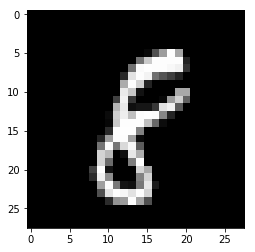

TypeError: imsave() missing 1 required positional argument: 'arr'

In [5]:
plt.imshow(X_train_img[0,:,:,0],cmap = 'gray')
plt.show()

## 2. A Typical CNN structure: one CNN layer.

 1. The original input image is $28\times28$, so the `input_shape=(28,28,1)`, where `1` indicates that number of color channels is 1. 
 
 2. In the following convolution layer, there are 32 filters, and each filters is $3\times3$.
  * You can set border differently by:
       ```
       border_mode='same', 'fall', or 'valid' (default)
       ```
  * With `valid` border, after convolution (with stride=0), the filted image size is `(28-2)x(28-2) = 26x26`  
    
  * Set stride 2 by `subsample=(2,2)`. Note that stride affect before applying filter. So now the filtered and subsampled image is $13 \times 13$
 
 3. There are $32\cdot3\cdot3+32 =320$ parameters.
   * Each "pixel" of the filted (and subsampled) image is obatained by $\sum_{i=1}^9 w_i x_i +b$, where $w_1,...,w_9,b\in \mathbb{R}^{10}$ are parameters and $(x_1,...,x_9)$ is a $3\times3$ image patches in the original input image.
   
 4. Using `relu` units by `activation='relu'`, then max Pooling by 2. So the output of this CNN layer will be $32$ of $6\times 6$ "images".
   
 5. If the next layer is 'softmax', one has to 'flatten' the output of the CNN layer. After flatten, the input of the next layer is of $6\cdot 6\cdot 32=1152$ values.
 
 6. So the last layer ('softmax') would require $1152\cdot 10+10$ parameters.


In [5]:
model = Sequential()
model.add(Conv2D(32, 3, 3,
                 activation='relu',subsample=(2,2),
                 input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten(name='flatten'))
model.add(Dense(10, activation='softmax'))
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 13, 13, 32)    320         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 6, 6, 32)      0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
flatten (Flatten)                (None, 1152)          0           maxpooling2d_1[0][0]             
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 10)            11530       flatten[0][0]                    
Total params: 11,850
Trainable params: 11,850
Non-trainable params: 0
_____________________

Before fitting the parameters, we need to compile the model first.

In [6]:
model.compile(loss='categorical_crossentropy',
              optimizer='RMSprop',
              metrics=['accuracy'])

We can now fit the parameters. Note that:
 * A better `batch_size` should be the exponent of 2, this is from the document of Keras.
 * Each epoch will scan through all the training data. Where each update of parameters uses `batch_size` of data (It will be chosen randomly through each epoch.)
 * `initial_epoch` allows you to continuoue your last parameter fitting.
 * verbose controls the infromation to be displayed. 0: no information displayed, 1: max infomation, 2: somewhat between.

In [11]:
batch_size = 64 
epochs = 20 
history = model.fit(X_train_img, y_train,
                    batch_size=batch_size,
                    nb_epoch=epochs,
                    verbose=2, 
                    validation_data=(X_val_img, y_val),
                    initial_epoch=10)

Train on 37800 samples, validate on 4200 samples
Epoch 11/20
3s - loss: 0.0478 - acc: 0.9864 - val_loss: 0.0749 - val_acc: 0.9764
Epoch 12/20
3s - loss: 0.0464 - acc: 0.9865 - val_loss: 0.0753 - val_acc: 0.9764
Epoch 13/20
3s - loss: 0.0453 - acc: 0.9872 - val_loss: 0.0741 - val_acc: 0.9769
Epoch 14/20
3s - loss: 0.0440 - acc: 0.9876 - val_loss: 0.0754 - val_acc: 0.9762
Epoch 15/20
3s - loss: 0.0431 - acc: 0.9880 - val_loss: 0.0731 - val_acc: 0.9769
Epoch 16/20
3s - loss: 0.0418 - acc: 0.9880 - val_loss: 0.0730 - val_acc: 0.9748
Epoch 17/20
3s - loss: 0.0413 - acc: 0.9888 - val_loss: 0.0766 - val_acc: 0.9755
Epoch 18/20
3s - loss: 0.0398 - acc: 0.9888 - val_loss: 0.0767 - val_acc: 0.9769
Epoch 19/20
3s - loss: 0.0394 - acc: 0.9891 - val_loss: 0.0763 - val_acc: 0.9779
Epoch 20/20
3s - loss: 0.0384 - acc: 0.9892 - val_loss: 0.0759 - val_acc: 0.9764


We can see that after 20 epoch, the validation accuracy is not improved (around 97.6%). The training set accuracy is about 98.8%. We should first try more complicated model to see if the training set accuracy get higher.

## 3. Stack more CNN layers

In the following model, we have:

#### 1. First CNN layer:
* The input is $28\times 28$
* Filter (kernel) size: $5\times 5$. With `valid` padding.
* Number of filters: 64.
* The output is 64 of $24\times 24$ filted images. i.e. $ 24\times 24\times 64$
* The number of parameters: $25\cdot 64+64=1664$.
    
#### 2. Second CNN layer:
* The input is $ 24\times 24\times 64$
* Filter (kernel) size: $3\times 3 \times 64$. With `valid` padding.
    * This might concern you a lot... is it resonable? The convolution aggregate through all the images of previous layer. A better design of this layer is to use more (or equal number) of filters (instead of 32, as I put here) than 64. I put 32 just for demonstration. 
* Number of filters: 32.
* The output is 32 of $22\times 22$ filted images. i.e. $22\times 22\times 32$
* The number of parameters: $3\cdot 3 \cdot 64\cdot 32+32 = 18464$.
    * Think this way: There are 64 nodes, and each node is $24\times 24$ filted images.
    
#### 3. Third: MaxPool layer: 
* The output is $11\times 11\times 32$

#### 4. Forth: A normal nural network layer with 128 nodes
* Each node here will connect to 32 nodes of previous layer. (Each node in previous layer is represented as a $11\times 11$ image.)
* The output is $11\times 11\times 128$.
* The number of parameters: $32\cdot 128+128=4224$
* Apply dropout rate 0.2 to prevent overfitting.

#### 5. Fifth: Flatten the output of the previous layer:
* The output is $11\cdot 11\cdot 128=15488$ nodes

#### 6. Final: 10 softmax units.
* The number of parameter: $15488*10+10=154898$

In [18]:
model = Sequential()
model.add(Conv2D(64, 5, 5,
                 activation='relu',
                 input_shape=(28,28,1)))
model.add(Conv2D(32, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))   
model.add(Flatten(name='flatten'))
model.add(Dense(10, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer='RMSprop',
              metrics=['accuracy'])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_12 (Convolution2D) (None, 24, 24, 64)    1664        convolution2d_input_7[0][0]      
____________________________________________________________________________________________________
convolution2d_13 (Convolution2D) (None, 22, 22, 32)    18464       convolution2d_12[0][0]           
____________________________________________________________________________________________________
maxpooling2d_7 (MaxPooling2D)    (None, 11, 11, 32)    0           convolution2d_13[0][0]           
____________________________________________________________________________________________________
dense_12 (Dense)                 (None, 11, 11, 128)   4224        maxpooling2d_7[0][0]             
___________________________________________________________________________________________

In [19]:
batch_size = 64
epochs = 5
history = model.fit(X_train_img, y_train,
                    batch_size=batch_size,
                    nb_epoch=epochs,
                    verbose=2, # verbose controls the infromation to be displayed. 0: no information displayed
                    validation_data=(X_val_img, y_val),
                    initial_epoch=0)


Train on 37800 samples, validate on 4200 samples
Epoch 1/5
104s - loss: 0.1609 - acc: 0.9504 - val_loss: 0.0661 - val_acc: 0.9793
Epoch 2/5
104s - loss: 0.0577 - acc: 0.9828 - val_loss: 0.0519 - val_acc: 0.9848
Epoch 3/5
104s - loss: 0.0435 - acc: 0.9867 - val_loss: 0.0411 - val_acc: 0.9883
Epoch 4/5
104s - loss: 0.0370 - acc: 0.9884 - val_loss: 0.0497 - val_acc: 0.9848
Epoch 5/5
105s - loss: 0.0317 - acc: 0.9902 - val_loss: 0.0411 - val_acc: 0.9867


The following function shows the wrongly predicted images. Many of them I can't even tell what it is...

4200/4200 [==============================] - 4s     

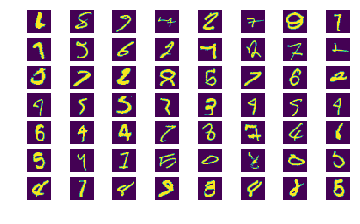

In [39]:
Aux_fcn.plot_difficult_samples(model,X_val_img,y_val,verbose=False)
plt.show()

## 4. Using the learned trained model to predict the test set.

In [35]:
pred_classes = model.predict_classes(X_test_img)

28000/28000 [==============================] - 30s     

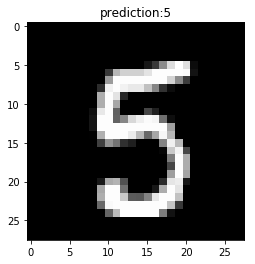

In [40]:
i=10
plt.imshow(X_test_img[i,:,:,0],cmap='gray')
plt.title('prediction:%d'%pred_classes[i])
plt.show()

## Appendix:

The function `Aux_fcn.plot_difficult_samples` is the following:

In [ ]:
def plot_difficult_samples(model,x,y, verbose=True):
    """
    x: size(n,h,w,c)
    y: is categorical, i.e. onehot, size(n,p)
    """ 
    #%%
    
    pred_classes = model.predict_classes(x)
    y_val_classes = np.argmax(y, axis=1)
    er_id = np.nonzero(pred_classes!=y_val_classes)[0]
    #%%
    K = np.ceil(np.sqrt(len(er_id)))
    fig = plt.figure()
    print('There are %d wrongly predicted images out of %d validation samples'%(len(er_id),x.shape[0]))
    for i in range(len(er_id)):
        ax = fig.add_subplot(K,K,i+1)
        k = er_id[i]
        ax.imshow(x[er_id[i],:,:,0])
        ax.axis('off')
        if verbose:
            ax.set_title('%d as %d'%(y_val_classes[k],pred_classes[k]))